## Importing reviews (annotations) from text files

In [ ]:
import os

gpt_folder = '../../datasets/gpt_cot_annotated/'
manual_folder = '../../datasets/manual_annotated/'

def read_files(folder):
    files = []
    for filename in os.listdir(folder):
        if filename.endswith(".txt"):
            with open(os.path.join(folder, filename), 'r') as file:
                files.append(file.read())
    return files

In [24]:
gpt_files = read_files(gpt_folder)
manual_files = read_files(manual_folder)

In [25]:
import re

def parse_review(review_text):
    match = re.search(r'\[\[\s*(.*?)\s*\]\]' , review_text, re.DOTALL)
    if match:
        annotations = match.group(1).split(',')
        annotations[0] = '[' + annotations[0]
        annotations[-1] = annotations[-1] + ']'
        annotations = [annotation[1:-1] for annotation in annotations]
        content = review_text[:match.start()].strip()
        return content, annotations
    return review_text, []

In [26]:
gpt_reviews = [parse_review(review) for review in gpt_files]
manual_reviews = [parse_review(review) for review in manual_files]

## Simple overall analysis

In [27]:
criteria = ['CLA', 'JUS', 'DEP', 'FAI', 'CON', 'ENG', 'ACC', 'CST', 'NOV', 'ETH']

def compare_annotations(gpt_ann, manual_ann):
    gpt_set = set(gpt_ann)
    manual_set = set(manual_ann)
    
    matches = len(gpt_set & manual_set)
    total = len(criteria)
    
    return matches, total - matches

In [28]:
comparison_results = []
for gpt, manual in zip(gpt_reviews, manual_reviews):
    gpt_content, gpt_ann = gpt
    manual_content, manual_ann = manual
    
    matches, differences = compare_annotations(gpt_ann, manual_ann)
    comparison_results.append((matches, differences))

In [29]:
total_matches = sum([result[0] for result in comparison_results])
total_differences = sum([result[1] for result in comparison_results])

print(f"Total Matches: {total_matches}")
print(f"Total Differences: {total_differences}")

Total Matches: 360
Total Differences: 90


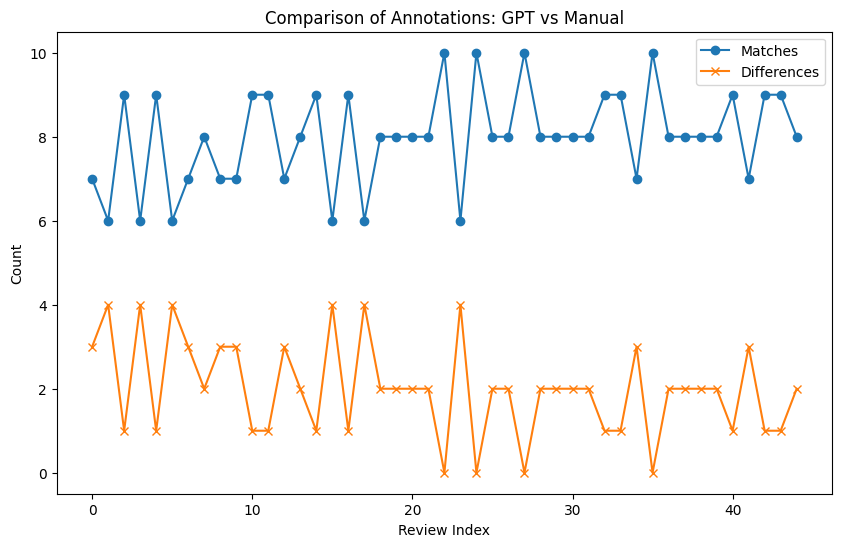

In [30]:
import matplotlib.pyplot as plt

matches = [result[0] for result in comparison_results]
differences = [result[1] for result in comparison_results]

plt.figure(figsize=(10, 6))
plt.plot(matches, label='Matches', marker='o')
plt.plot(differences, label='Differences', marker='x')
plt.xlabel('Review Index')
plt.ylabel('Count')
plt.title('Comparison of Annotations: GPT vs Manual')
plt.legend()
plt.show()

## Detailed analysis per criterion

In [31]:
from collections import defaultdict

detailed_comparison = defaultdict(lambda: {'matches': 0, 'differences': 0})

def detailed_compare_annotations(gpt_ann, manual_ann):
    gpt_dict = {ann.split('-')[0]: ann.split('-')[1] for ann in gpt_ann}
    manual_dict = {ann.split('-')[0]: ann.split('-')[1] for ann in manual_ann}

    for criterion in criteria:
        if criterion in gpt_dict and criterion in manual_dict:
            if gpt_dict[criterion] == manual_dict[criterion]:
                detailed_comparison[criterion]['matches'] += 1
            else:
                detailed_comparison[criterion]['differences'] += 1

In [32]:
for gpt, manual in zip(gpt_reviews, manual_reviews):
    gpt_content, gpt_ann = gpt
    manual_content, manual_ann = manual
    detailed_compare_annotations(gpt_ann, manual_ann)

In [33]:
for criterion, result in detailed_comparison.items():
    print(f"{criterion}: Matches = {result['matches']}, Differences = {result['differences']}")

CLA: Matches = 45, Differences = 0
JUS: Matches = 38, Differences = 7
DEP: Matches = 30, Differences = 15
FAI: Matches = 33, Differences = 12
CON: Matches = 44, Differences = 1
ENG: Matches = 29, Differences = 16
ACC: Matches = 45, Differences = 0
CST: Matches = 45, Differences = 0
NOV: Matches = 10, Differences = 35
ETH: Matches = 41, Differences = 4


## Statistical Analysis

In [34]:
from sklearn.metrics import f1_score, classification_report

manual_flat = []
gpt_flat = []

for gpt, manual in zip(gpt_reviews, manual_reviews):
    _, gpt_ann = gpt
    _, manual_ann = manual
    
    gpt_dict = {ann.split('-')[0]: ann.split('-')[1] for ann in gpt_ann}
    manual_dict = {ann.split('-')[0]: ann.split('-')[1] for ann in manual_ann}

    for criterion in criteria:
        manual_flat.append(manual_dict.get(criterion, 'NEG')) 
        gpt_flat.append(gpt_dict.get(criterion, 'NEG'))

In [38]:
f1 = f1_score(manual_flat, gpt_flat, pos_label='POS')
print(f"F1-Score (POS): {f1:.3f}")
f1 = f1_score(manual_flat, gpt_flat, pos_label='NEG')
print(f"F1-Score (NEG): {f1:.3f}")

F1-Score (POS): 0.871
F1-Score (NEG): 0.550


In [37]:
report = classification_report(manual_flat, gpt_flat, target_names=['NEG', 'POS'])
print(report)

              precision    recall  f1-score   support

         NEG       0.40      0.86      0.55        64
         POS       0.97      0.79      0.87       386

    accuracy                           0.80       450
   macro avg       0.69      0.82      0.71       450
weighted avg       0.89      0.80      0.83       450



### Inferences

#### The match and difference patterns across criteria provide some insights:

CLA (Clarity), ACC (Accuracy), CST (Consistency): These show perfect alignment between the GPT and manual annotations, indicating that both agree fully on these aspects.

JUS (Justification), CON (Constructiveness), ETH (Ethical Considerations): These also have high agreement with small differences, suggesting a strong alignment in how GPT and manual annotations handle these categories.

DEP (Depth), FAI (Fairness), ENG (Engagement), NOV (Novelty): These criteria have higher mismatches, with NOV standing out as the criterion with the largest disagreement. It seems that either the GPT model is interpreting these concepts differently or the manual annotator has stricter criteria.

#### Potential Hypotheses:

NOV (Identification of Novelty): This high mismatch suggests that GPT might struggle to identify novelty in research. The task may require deeper domain-specific understanding or subjective interpretation.

ENG (Engagement with Related Work): GPT could be more generic or less sensitive to nuanced engagement with literature, which could explain the lower match rates.

## Deeper Visualization

In [39]:
from sklearn.metrics import f1_score

f1_scores = {}

for criterion in criteria:
    gpt_ann = []
    manual_ann = []
    
    for gpt, manual in zip(gpt_reviews, manual_reviews):
        gpt_content, gpt_annotations = gpt
        manual_content, manual_annotations = manual

        gpt_dict = {ann.split('-')[0]: ann.split('-')[1] for ann in gpt_annotations}
        manual_dict = {ann.split('-')[0]: ann.split('-')[1] for ann in manual_annotations}

        gpt_ann.append(gpt_dict.get(criterion, 'NEG'))
        manual_ann.append(manual_dict.get(criterion, 'NEG'))

    f1_scores[criterion] = f1_score(manual_ann, gpt_ann, pos_label='POS')

In [40]:
for criterion, f1 in f1_scores.items():
    print(f"{criterion}: F1-Score = {f1:.3f}")

CLA: F1-Score = 1.000
JUS: F1-Score = 0.907
DEP: F1-Score = 0.694
FAI: F1-Score = 0.829
CON: F1-Score = 0.989
ENG: F1-Score = 0.333
ACC: F1-Score = 1.000
CST: F1-Score = 1.000
NOV: F1-Score = 0.103
ETH: F1-Score = 0.952


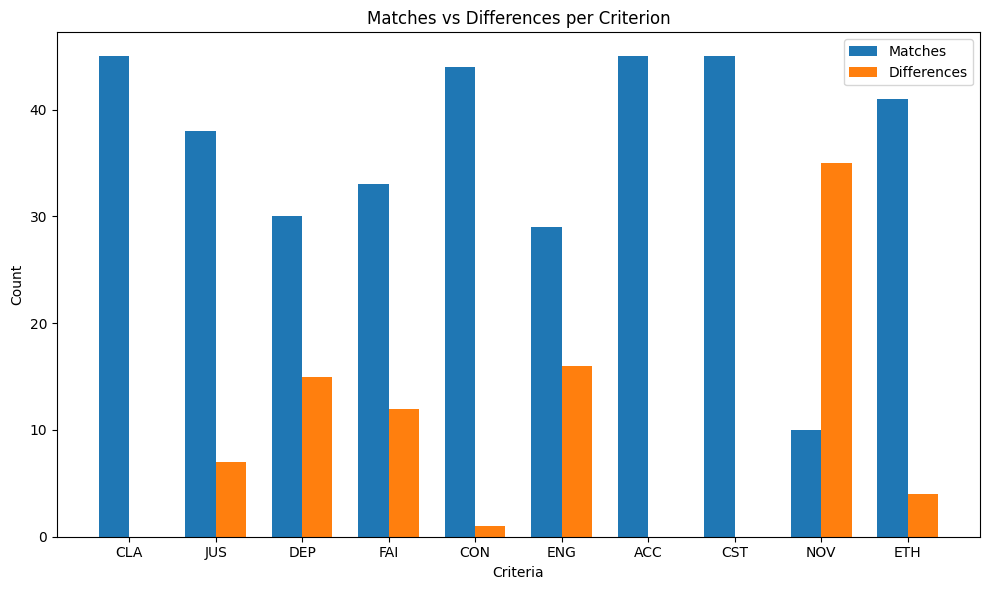

In [41]:
import matplotlib.pyplot as plt
import numpy as np

criteria = ['CLA', 'JUS', 'DEP', 'FAI', 'CON', 'ENG', 'ACC', 'CST', 'NOV', 'ETH']
matches = [45, 38, 30, 33, 44, 29, 45, 45, 10, 41]
differences = [0, 7, 15, 12, 1, 16, 0, 0, 35, 4]

fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(criteria))
bar_width = 0.35

bars1 = ax.bar(index, matches, bar_width, label='Matches')
bars2 = ax.bar(index + bar_width, differences, bar_width, label='Differences')

ax.set_xlabel('Criteria')
ax.set_ylabel('Count')
ax.set_title('Matches vs Differences per Criterion')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(criteria)
ax.legend()

plt.tight_layout()
plt.show()